In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D, SimpleRNN
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer


from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf

import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
rcv1_train = pd.read_csv("/content/drive/MyDrive/ReutersTextClassification/Datasets/RCV1/rcv1_train_data_formatted.csv")
rcv1_test=pd.read_csv("/content/drive/MyDrive/ReutersTextClassification/Datasets/RCV1/rcv1_test_data_formatted.csv")

codes=[]
with open('/content/drive/MyDrive/ReutersTextClassification/Datasets/RCV1/rcv1.topics.txt','r') as f:
  lines=f.readlines()
  for line in lines:
    codes.append(line.rstrip())
print(len(codes))
print(codes)


rcv1_train_labels = rcv1_train[codes]
rcv1_test_labels = rcv1_test[codes]

103
['C11', 'C12', 'C13', 'C14', 'C15', 'C151', 'C1511', 'C152', 'C16', 'C17', 'C171', 'C172', 'C173', 'C174', 'C18', 'C181', 'C182', 'C183', 'C21', 'C22', 'C23', 'C24', 'C31', 'C311', 'C312', 'C313', 'C32', 'C33', 'C331', 'C34', 'C41', 'C411', 'C42', 'CCAT', 'E11', 'E12', 'E121', 'E13', 'E131', 'E132', 'E14', 'E141', 'E142', 'E143', 'E21', 'E211', 'E212', 'E31', 'E311', 'E312', 'E313', 'E41', 'E411', 'E51', 'E511', 'E512', 'E513', 'E61', 'E71', 'ECAT', 'G15', 'G151', 'G152', 'G153', 'G154', 'G155', 'G156', 'G157', 'G158', 'G159', 'GCAT', 'GCRIM', 'GDEF', 'GDIP', 'GDIS', 'GENT', 'GENV', 'GFAS', 'GHEA', 'GJOB', 'GMIL', 'GOBIT', 'GODD', 'GPOL', 'GPRO', 'GREL', 'GSCI', 'GSPO', 'GTOUR', 'GVIO', 'GVOTE', 'GWEA', 'GWELF', 'M11', 'M12', 'M13', 'M131', 'M132', 'M14', 'M141', 'M142', 'M143', 'MCAT']


In [ ]:
rcv1_train["newsitem"] = rcv1_train["newsitem"].str.lower()
rcv1_test["newsitem"] = rcv1_test["newsitem"].str.lower()

In [ ]:
import re
#preprocess step
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', str(sen))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', str(sentence))

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', str(sentence))

    return sentence

rcv1_train["newsitem"] = rcv1_train["newsitem"].apply(lambda x: preprocess_text(x))
rcv1_test["newsitem"] = rcv1_test["newsitem"].apply(lambda x: preprocess_text(x))

In [ ]:
print('average train sentence length: ', rcv1_train.newsitem.str.split().str.len().mean())
print('stdev train sentence length: ', rcv1_train.newsitem.str.split().str.len().std())

average train sentence length:  204.10229383558686
stdev train sentence length:  189.21434973921873


In [ ]:
print('average test sentence length: ', rcv1_test.newsitem.str.split().str.len().mean())
print('stdev test sentence length: ', rcv1_test.newsitem.str.split().str.len().std())

average test sentence length:  209.47152886664577
stdev test sentence length:  195.82496640697397


In [ ]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = None # how many unique words to use (i.e num rows in embedding vector)
maxlen = 1500 # max number of words in a question to use #99.99%

## fill up the missing values
X = rcv1_train["newsitem"].fillna("_na_").values
X_test = rcv1_test["newsitem"].fillna("_na_").values

In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters='')
tokenizer.fit_on_texts(list(X))

X = tokenizer.texts_to_sequences(X)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
## Pad the sentences 
X = pad_sequences(X, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## Get the target values


Y = rcv1_train_labels.values
Y_test = rcv1_test_labels.values

In [ ]:
import gc
del rcv1_train, rcv1_test
gc.collect()

word_index = tokenizer.word_index
max_features = len(word_index)+1
def load_glove(word_index):
    EMBEDDING_FILE = '/content/drive/MyDrive/ReutersTextClassification/WordEmbedding/Glove_6B/glove.6B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if o.split(" ")[0] in word_index)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

def load_fasttext(word_index):    
    EMBEDDING_FILE = '/content/drive/MyDrive/ReutersTextClassification/WordEmbedding/Fasttext/wiki-news-300d-1M.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100 and o.split(" ")[0] in word_index )

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_para(word_index):
    EMBEDDING_FILE = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100 and o.split(" ")[0] in word_index)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix






In [ ]:
embedding_matrix = load_glove(word_index)
#embedding_matrix_2 = load_fasttext(word_index)
#embedding_matrix_3 = load_para(word_index)
#embedding_matrix = np.mean((embedding_matrix_1, embedding_matrix_3), axis=0)  
#del embedding_matrix_1, embedding_matrix_3
gc.collect()
np.shape(embedding_matrix)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(67683, 300)

In [ ]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [ ]:
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]




In [ ]:
# https://www.kaggle.com/yekenot/2dcnn-textclassifier
def model_cnn(embedding_matrix):
    filter_sizes = [1,2,3,5]
    num_filters = 128

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable=True)(inp)
    x = Reshape((maxlen, embed_size, 1))(x)

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                     kernel_initializer='he_normal', activation='relu')(x)
        maxpool_pool.append(MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))

    z = Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    outp = Dense(len(codes), activation="sigmoid")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def model_cnn_self():
    filter_sizes = [1,2,3,5]
    num_filters = 128

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size)(inp)
    x = Reshape((maxlen, embed_size, 1))(x)

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                     kernel_initializer='he_normal', activation='relu')(x)
        maxpool_pool.append(MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))

    z = Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    outp = Dense(len(codes), activation="sigmoid")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
  
def simpleRNN(embedding_matrix):

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable=True,mask_zero=True)(inp)
    #x = Reshape((maxlen, embed_size, 1))(x)

    y = SimpleRNN(256,activation="relu")(x)
    z = Dense(128)(y)
    z = Dropout(0.1)(z)
    outp = Dense(len(codes),activation="sigmoid")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def simpleRNN_self():

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size,mask_zero=True)(inp)
    #x = Reshape((maxlen, embed_size, 1))(x)

    y = SimpleRNN(256,activation="relu")(x)
    z = Dense(128)(y)
    z = Dropout(0.1)(z)
    outp = Dense(len(codes),activation="sigmoid")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def LSTM_CLASSIFIER(embedding_matrix):

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable=False,mask_zero=True)(inp)
    #x = Reshape((maxlen, embed_size, 1))(x)

    y = LSTM(128, dropout=0.1, activation="tanh")(x)
    #z = Dense(128)(y)
    #z = Dropout(0.1)(z)
    outp = Dense(len(codes),activation="sigmoid")(y)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def LSTM_CLASSIFIER_self():

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size,mask_zero=True)(inp)
    #x = Reshape((maxlen, embed_size, 1))(x)

    y = LSTM(128, dropout=0.1, activation="tanh")(x)
    #z = Dense(128)(y)
    #z = Dropout(0.1)(z)
    outp = Dense(len(codes),activation="sigmoid")(y)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def GRU_CLASSIFIER(embedding_matrix):

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable=True,mask_zero=True)(inp)
    #x = Reshape((maxlen, embed_size, 1))(x)

    y = GRU(128, dropout=0.1, activation="tanh")(x)
    #z = Dense(128)(y)
    #z = Dropout(0.1)(z)
    outp = Dense(len(codes),activation="sigmoid")(y)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def GRU_CLASSIFIER_self():

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, mask_zero=True)(inp)
    #x = Reshape((maxlen, embed_size, 1))(x)

    y = GRU(128, dropout=0.1, activation="tanh")(x)
    #z = Dense(128)(y)
    #z = Dropout(0.1)(z)
    outp = Dense(len(codes),activation="sigmoid")(y)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def BI_LSTM_CLASSIFIER(embedding_matrix):

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable=True,mask_zero=True)(inp)
    #x = Reshape((maxlen, embed_size, 1))(x)

    y = Bidirectional(LSTM(128, dropout=0.1, activation="tanh"))(x)
    #z = Dense(128)(y)
    #z = Dropout(0.1)(z)
    outp = Dense(len(codes),activation="sigmoid")(y)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def BI_LSTM_CLASSIFIER_self():

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, mask_zero=True)(inp)
    #x = Reshape((maxlen, embed_size, 1))(x)

    y = Bidirectional(LSTM(128, dropout=0.1, activation="tanh"))(x)
    #z = Dense(128)(y)
    #z = Dropout(0.1)(z)
    outp = Dense(len(codes),activation="sigmoid")(y)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def BI_GRU_CLASSIFIER(embedding_matrix):

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable=True,mask_zero=True)(inp)
    #x = Reshape((maxlen, embed_size, 1))(x)

    y = Bidirectional(GRU(128, dropout=0.1, activation="tanh"))(x)
    #z = Dense(128)(y)
    #z = Dropout(0.1)(z)
    outp = Dense(len(codes),activation="sigmoid")(y)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def BI_GRU_CLASSIFIER_self():

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, mask_zero=True)(inp)
    #x = Reshape((maxlen, embed_size, 1))(x)

    y = Bidirectional(GRU(128, dropout=0.1, activation="tanh"))(x)
    #z = Dense(128)(y)
    #z = Dropout(0.1)(z)
    outp = Dense(len(codes),activation="sigmoid")(y)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def model_lstm_attention(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inp)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = AttentionWithContext()(x)
    #x = Dense(64, activation="relu")(x)
    x = Dense(len(codes), activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def model_lstm_attention_self():
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, mask_zero=True)(inp)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = AttentionWithContext()(x)
    #x = Dense(64, activation="relu")(x)
    x = Dense(len(codes), activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def model_gru_attention(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True, mask_zero=True)(inp)
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = AttentionWithContext()(x)
    #x = Dense(64, activation="relu")(x)
    x = Dense(len(codes), activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def model_gru_attention_self():
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, mask_zero=True)(inp)
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = AttentionWithContext()(x)
    #x = Dense(64, activation="relu")(x)
    x = Dense(len(codes), activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model = model_cnn(embedding_matrix)

In [ ]:
filepath='/content/drive/MyDrive/Colab Notebooks/Models/text_cnn_500_trainabe_true_fasttext.hd5f'

In [ ]:
filepath='/content/drive/MyDrive/Colab Notebooks/Models/text_cnn_500_trainabe_true_fasttext.hd5f'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=1, min_lr=0.0001, verbose=2)
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=2, mode='auto')

callbacks = [checkpoint, earlystopping]

x_train = X
y_train = np.asarray(Y)

history = model.fit(x_train, y_train, batch_size=32, epochs=1000, verbose=1, validation_split=0.2,callbacks=callbacks)
        


Epoch 1/1000
579/579 [==============================] - 272s 469ms/step - loss: 0.0971 - accuracy: 0.2431 - val_loss: 0.0420 - val_accuracy: 0.2890

Epoch 00001: val_loss improved from inf to 0.04203, saving model to /content/drive/MyDrive/Colab Notebooks/Models/text_cnn_500_trainabe_true_fasttext.hd5f
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Models/text_cnn_500_trainabe_true_fasttext.hd5f/assets
Epoch 2/1000
579/579 [==============================] - 269s 464ms/step - loss: 0.0328 - accuracy: 0.3002 - val_loss: 0.0377 - val_accuracy: 0.2600

Epoch 00002: val_loss improved from 0.04203 to 0.03769, saving model to /content/drive/MyDrive/Colab Notebooks/Models/text_cnn_500_trainabe_true_fasttext.hd5f
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Models/text_cnn_500_trainabe_true_fasttext.hd5f/assets
Epoch 3/1000
579/579 [==============================] - 270s 467ms/step - loss: 0.0216 - accuracy: 0.3049 - val_loss: 0.0359 - val

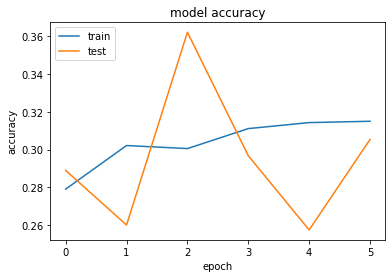

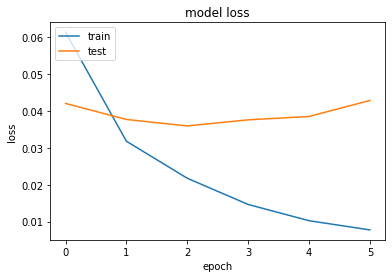

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
model = tf.keras.models.load_model(filepath)

In [ ]:
predictions=model.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
#delta, _ = bestThresshold(Y_test,predictions)

In [ ]:
pred_bools = [pl>0.50 for pl in predictions] #boolean output after thresholding

#Print and save classification report
print('Test F1 Accuracy(Micro): ', f1_score(Y_test, pred_bools,average='micro'))
print('Test F1 Accuracy(Macro): ', f1_score(Y_test, pred_bools,average='macro'))
print('Test Flat Accuracy: ', accuracy_score(Y_test, pred_bools),'\n')

In [ ]:
m = tf.keras.metrics.Precision(top_k=1)
m.update_state(Y_test, pred_bools)
m.result().numpy()

In [ ]:
m = tf.keras.metrics.Precision(top_k=3)
m.update_state(Y_test, pred_bools)
m.result().numpy()

In [ ]:
m = tf.keras.metrics.Precision(top_k=5)
m.update_state(Y_test, pred_bools)
m.result().numpy()

In [ ]:
def precision(actual, predicted, k):
    act_set = set(actual.flatten())
    pred_set = set(predicted[:k].flatten())
    result = len(act_set & pred_set) / float(k)
    return result

pred_bools=np.array(pred_bools)

In [ ]:
precision(Y_test,pred_bools,3)